In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from io import open
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import time
# from scipy.stats import gaussian_kde
# import scipy.stats as stats

In [2]:
# To import dataset and time_series_models succesful,
# here need to set correct path
import sys
import os
current_dir = os.path.dirname(os.path.abspath(''))
parent_dir = os.path.dirname(current_dir)

# here add current path. Please check the value of current_dir and parent_dir
sys.path.append(current_dir)

In [3]:
from dataset import CO2_synthetic_dataset
from time_series_models import GRUSeq2SeqWithAttention, TimeSeriesModel, SequenceDataset
# from sequence_dataset import SequenceDataset, train_test_split

In [4]:
import kgml_lib

In [5]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [6]:
# define functions from kgml_lib
Z_norm = kgml_lib.Z_norm 
Z_norm_reverse = kgml_lib.Z_norm_reverse
get_gpu_memory = kgml_lib.get_gpu_memory

In [7]:
root_dir = 'E:/PyKGML/deposit_code_v2/'
data_path = root_dir +  'processed_data/'
output_path = root_dir + 'test_results/'

input_data = 'recotest_data_scaled_v4_100sample.sav'
sample_index_file = "traindataset_split_year_v1.sav"

pretrained_model = "recotest_v11_exp4.sav_step1"
output_model = "recotest_v11_exp4_sample.sav_step2"
synthetic_data = "sys_data2.sav"

dataset = CO2_synthetic_dataset(data_path, input_data, output_path, sample_index_file)
dataset.load_step2_data()

dataset.prepare_step2_data()

torch.Size([6570, 100, 19]) torch.Size([6570, 100, 3]) torch.Size([18, 100, 1])
['RADN', 'TMAX_AIR', 'TDIF_AIR', 'HMAX_AIR', 'HDIF_AIR', 'WIND', 'PRECN', 'Crop_Type', 'GPP', 'Year', 'TBKDS', 'TSAND', 'TSILT', 'TFC', 'TWP', 'TKSat', 'TSOC', 'TPH', 'TCEC']


In [8]:
X = dataset.X  #[365*18, 100, 19]
X = torch.transpose(X,1, 0) #[100, 365*18, 19]

Y1 = dataset.Y1 #[365*18, 100, 3]
Y1 = torch.transpose(Y1,1, 0) #[100, 365*18, 3]

Y2 = dataset.Y2 #[18, 100, 1]
Y2 = torch.transpose(Y2,1, 0)

y_scaler = dataset.Y1_scaler


In [8]:
co2_pretrain_file = data_path + 'co2_pretrain_data.sav'
torch.save({'X': X,
            'Y': Y1,
            'y_scaler': y_scaler}, co2_pretrain_file)

In [9]:
num_input_features = 19
num_output_features = 3

input_dim = num_input_features
hidden_dim = 128
num_layers = 3
output_dim = num_output_features
dropout=0.2

In [10]:
# Choose one of the models below:
#model = LSTMSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)
# model = GRUSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)

# model = EnhancedGRUModel(input_dim, hidden_dim, num_layers, output_dim)

# model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim)

In [11]:
total_years = 18
# days_per_year = 365
# total_days = total_years * days_per_year
# num_sites = X.shape[0] #100

batch_size=64

model.train_test_split(X, Y1, total_years, batch_size, split_method=1)

In [12]:
learning_rate = 0.001
step_size = 20
max_epoch = 60
loss_function = nn.L1Loss()

# model.train_model(train_loader, test_loader, LR= learning_rate, step_size=20, gamma=0.8, maxepoch=60)
model.train_model(loss_fun=loss_function, LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/60 | LR: 0.001000, Train Loss: 0.6286, Test Loss: 0.5122
Epoch 2/60 | LR: 0.001000, Train Loss: 0.4620, Test Loss: 0.4175
Epoch 3/60 | LR: 0.001000, Train Loss: 0.3690, Test Loss: 0.3172
Epoch 4/60 | LR: 0.001000, Train Loss: 0.2935, Test Loss: 0.2663
Epoch 5/60 | LR: 0.001000, Train Loss: 0.2584, Test Loss: 0.2445
Epoch 6/60 | LR: 0.001000, Train Loss: 0.2386, Test Loss: 0.2223
Epoch 7/60 | LR: 0.001000, Train Loss: 0.2246, Test Loss: 0.2136
Epoch 8/60 | LR: 0.001000, Train Loss: 0.2136, Test Loss: 0.2047
Epoch 9/60 | LR: 0.001000, Train Loss: 0.2025, Test Loss: 0.1962
Epoch 10/60 | LR: 0.001000, Train Loss: 0.1912, Test Loss: 0.1903
Epoch 11/60 | LR: 0.001000, Train Loss: 0.1828, Test Loss: 0.1851
Epoch 12/60 | LR: 0.001000, Train Loss: 0.1747, Test Loss: 0.1830
Epoch 13/60 | LR: 0.001000, Train Loss: 0.1692, Test Loss: 0.1841
Epoch 14/60 | LR: 0.001000, Train Loss: 0.1655, Test Loss: 0.1848
Epoch 15/60 | LR: 0.001000, Train Loss: 0.1618, Test Loss: 0.1811
Epoch 16/60 | LR: 0

In [13]:
model.test()

Test Loss: 0.1632


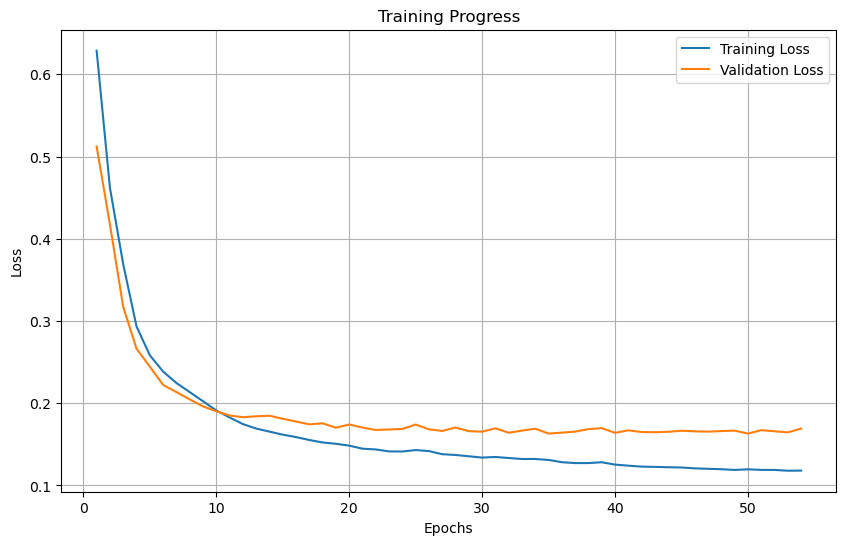

In [14]:
model.plot_training_curves()

In [15]:
output_feature_name = ['Ra','Rh','NEE']
model.get_R2_score(y_scaler, output_feature_name)

Feature Ra R2 Score is: 0.9467887402304173
Feature Rh R2 Score is: 0.7821217801432909
Feature NEE R2 Score is: 0.9473269363111277


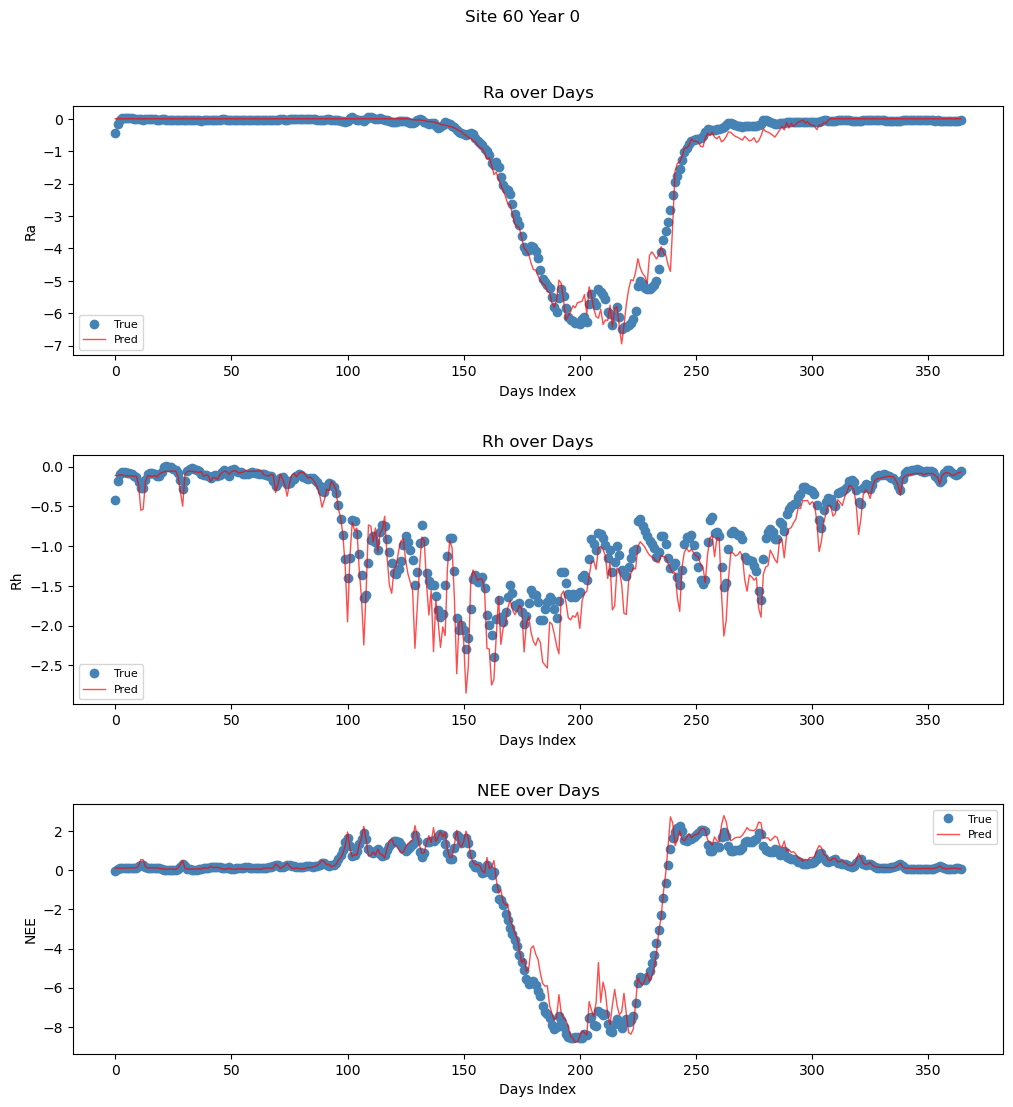

In [16]:
model.Vis_plot_prediction_result_time_series(y_scaler, output_feature_name, site=60, year=0)

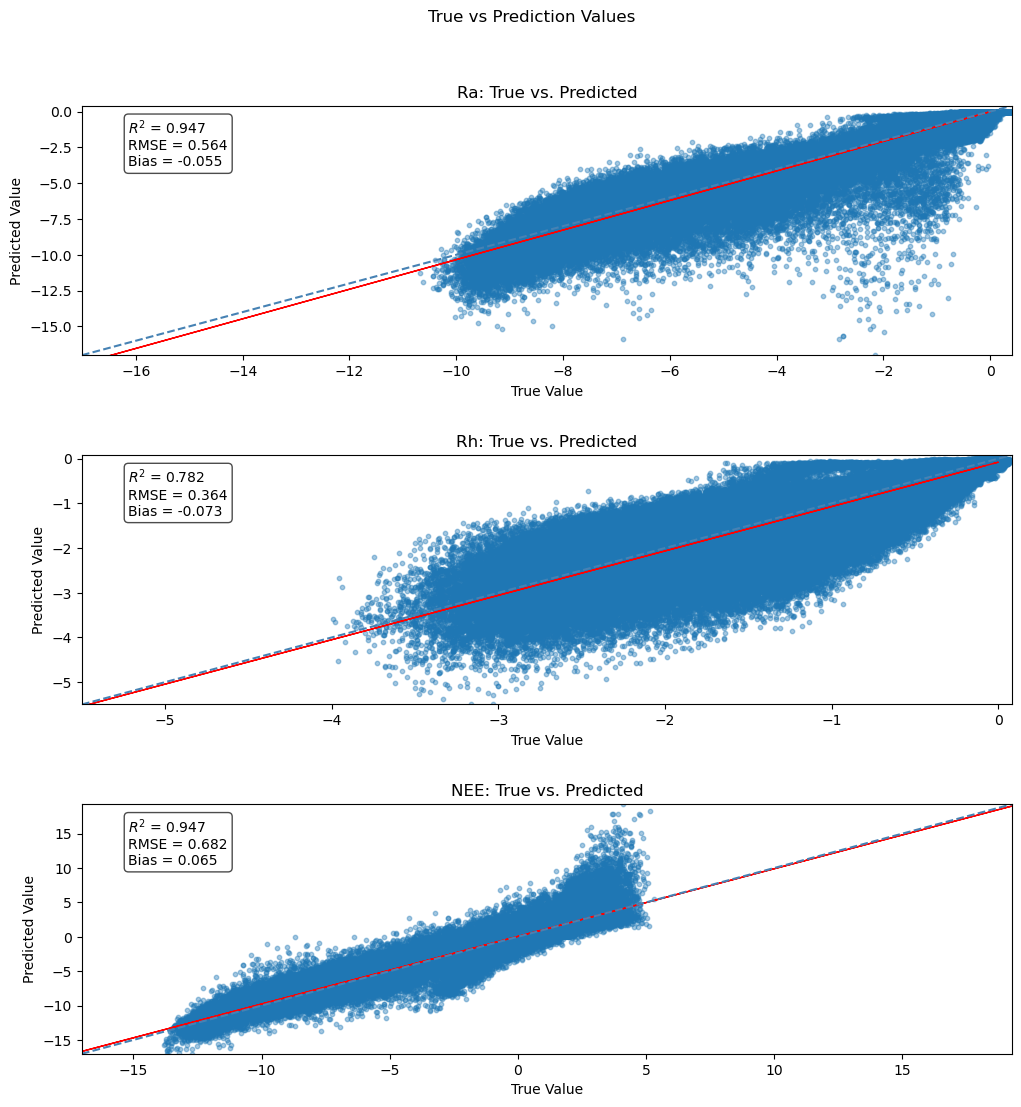

In [17]:
model.Vis_scatter_prediction_result(y_scaler, output_feature_name)